In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
# read data
data = pd.read_csv('/home/mirza/Documents/ijs_naloga-main/data/data60.csv', low_memory=False)
# replace ? for NAN
data = data.replace('?', np.nan)
# Delete rows with missing values
data = data.dropna()
data = data.astype(float)
data = data[:10000]
target_columns = data.iloc[:,-33:].columns
data['target'] = data.loc[:, target_columns].astype(float).sum(axis=1)
data.drop(columns=target_columns, inplace=True)

data["ut_ms"] = [datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d, %H:%M:%S') for x in data["ut_ms"]]
data["ut_ms"] = pd.to_datetime(data["ut_ms"])
data = data.set_index("ut_ms")

print(f"Data shape (resolution 60min) : {data.shape}\nNumber of rows {data.shape[0]}\nNumber of columns {data.shape[1]}")

Data shape (resolution 60min) : (10000, 485)
Number of rows 10000
Number of columns 485


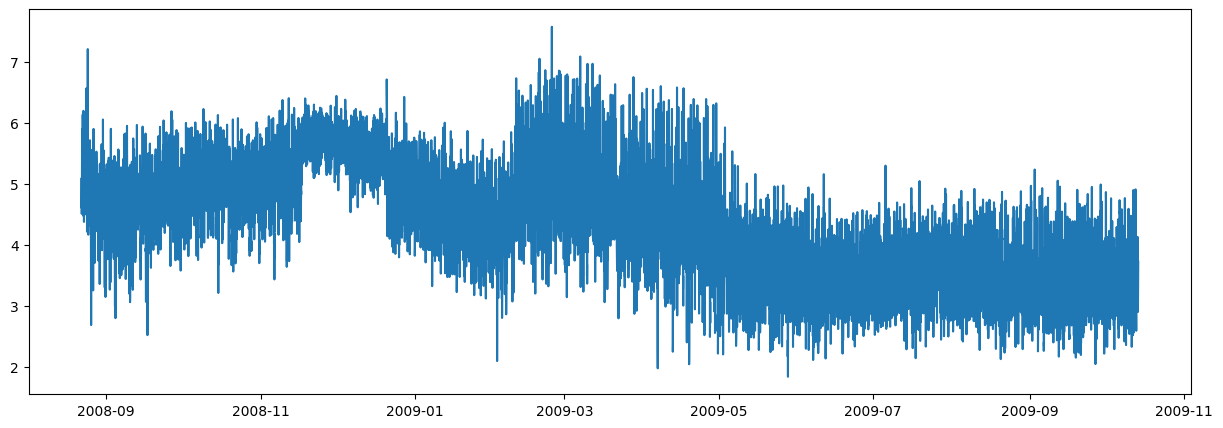

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data["target"])

In [3]:
# convert series to supervised learning
def data_preparation(data, look_back=1, look_forward=1, dropnan=True):
    '''
    Input : 
    data - Sequence data for preparation to TS format. Must be in shape (m, n)
    look_back - Number of past timestamps we want to use to predict the future.
    look_forward - Number of future timestamps we want to forecast.
    dropnan - Drop NA rows.

    Return : 
    Data in TimeseriesFormat - (np.array).
    Target value - (np.array).
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(look_back, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, look_forward):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.iloc[:,:data.shape[1] * look_back], agg.iloc[:,[agg.shape[1] - 1]]
    #return np.array(agg.values[:,:data.shape[1]*look_back]), np.array(agg.values[:,agg.shape[1]-1])

# RNN-LSTM and Feedforward-NN in Tensorflow and Keras API

## Only target feature - LSTM

In [54]:
# Split data
look_back = 48
target_train = data.iloc[:int(len(data) * 0.7),data.shape[1] - 1].values
target_val = data.iloc[(int(len(data) * 0.7) - look_back):int(len(data) * 0.9),data.shape[1] - 1].values
target_test = data.iloc[(int(len(data) * 0.9) - look_back):,data.shape[1] - 1].values

# scale data
scaler = StandardScaler().fit(target_train.reshape(-1,1))
target_train = scaler.transform(target_train.reshape(-1,1))
target_val = scaler.transform(target_val.reshape(-1,1))
target_test = scaler.transform(target_test.reshape(-1,1))

# Preprocess data
x_train,  y_train = data_preparation(target_train, look_back)
x_val,  y_val = data_preparation(target_val, look_back)
x_test,  y_test = data_preparation(target_test, look_back)
x_train.shape, x_val.shape, x_test.shape

((6952, 48), (2000, 48), (1000, 48))

### Podatkovni okvir zgradimo iz podatkov spremenljivke target:
* $t - 1, t - 2, ... t - look\_back$

* Model učimo napovedati vrednosti target spremenljivke v času t.

In [6]:
x_train

,var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
48,0.047107,-0.064310,0.516084,-0.182856,0.052041,0.659723,1.286189,0.292189,1.027353,1.474290,...,0.668908,1.187993,0.789060,0.328940,0.395215,-0.192601,0.605421,1.615293,0.976968,2.262445
49,-0.064310,0.516084,-0.182856,0.052041,0.659723,1.286189,0.292189,1.027353,1.474290,0.676250,...,1.187993,0.789060,0.328940,0.395215,-0.192601,0.605421,1.615293,0.976968,2.262445,1.527220
50,0.516084,-0.182856,0.052041,0.659723,1.286189,0.292189,1.027353,1.474290,0.676250,0.791266,...,0.789060,0.328940,0.395215,-0.192601,0.605421,1.615293,0.976968,2.262445,1.527220,1.061293
51,-0.182856,0.052041,0.659723,1.286189,0.292189,1.027353,1.474290,0.676250,0.791266,1.752380,...,0.328940,0.395215,-0.192601,0.605421,1.615293,0.976968,2.262445,1.527220,1.061293,0.603512
52,0.052041,0.659723,1.286189,0.292189,1.027353,1.474290,0.676250,0.791266,1.752380,0.642115,...,0.395215,-0.192601,0.605421,1.615293,0.976968,2.262445,1.527220,1.061293,0.603512,0.351786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,-2.217773,-1.821856,-2.218082,-1.026409,-1.313996,-1.492745,-1.360829,-2.681179,-2.174899,-1.825169,...,-1.171972,-2.131793,-1.674011,-2.162125,-2.662556,-2.134253,-1.066268,-0.833343,-1.376331,-0.903876
6996,-1.821856,-2.218082,-1.026409,-1.313996,-1.492745,-1.360829,-2.681179,-2.174899,-1.825169,-0.482866,...,-2.131793,-1.674011,-2.162125,-2.662556,-2.134253,-1.066268,-0.833343,-1.376331,-0.903876,-1.604936
6997,-2.218082,-1.026409,-1.313996,-1.492745,-1.360829,-2.681179,-2.174899,-1.825169,-0.482866,-1.532348,...,-1.674011,-2.162125,-2.662556,-2.134253,-1.066268,-0.833343,-1.376331,-0.903876,-1.604936,-1.992333
6998,-1.026409,-1.313996,-1.492745,-1.360829,-2.681179,-2.174899,-1.825169,-0.482866,-1.532348,-1.800825,...,-2.162125,-2.662556,-2.134253,-1.066268,-0.833343,-1.376331,-0.903876,-1.604936,-1.992333,-2.004709


In [7]:
y_train

,var1(t)
48,1.527220
49,1.061293
50,0.603512
51,0.351786
52,-0.398320
...,...
6995,-1.604936
6996,-1.992333
6997,-2.004709
6998,-1.255970


In [15]:
x_train = np.reshape(x_train.values, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val.values, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test.values, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape, x_val.shape, x_test.shape

((6952, 48, 1), (2000, 48, 1), (1000, 48, 1))

In [9]:
# Build the LSTM model
model = Sequential(name = 'LSTM')
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

2023-12-19 19:13:12.692650: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33     

In [10]:
# Train the model
history_lstm1 = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
55/55 [==============================] - 18s 183ms/step - loss: 0.6139 - val_loss: 0.4819
Epoch 2/50
55/55 [==============================] - 8s 151ms/step - loss: 0.5766 - val_loss: 0.4247
Epoch 3/50
55/55 [==============================] - 8s 152ms/step - loss: 0.5769 - val_loss: 0.4755
Epoch 4/50
55/55 [==============================] - 8s 152ms/step - loss: 0.5567 - val_loss: 0.4315
Epoch 5/50
55/55 [==============================] - 8s 153ms/step - loss: 0.5598 - val_loss: 0.4270
Epoch 6/50
55/55 [==============================] - 8s 150ms/step - loss: 0.5583 - val_loss: 0.4483
Epoch 7/50
55/55 [==============================] - 8s 149ms/step - loss: 0.5481 - val_loss: 0.4059
Epoch 8/50
55/55 [==============================] - 8s 149ms/step - loss: 0.5459 - val_loss: 0.3991
Epoch 9/50
55/55 [==============================] - 8s 150ms/step - loss: 0.5376 - val_loss: 0.4164
Epoch 10/50
55/55 [==============================] - 8s 149ms/step - loss: 0.5286 - val_loss: 0.355

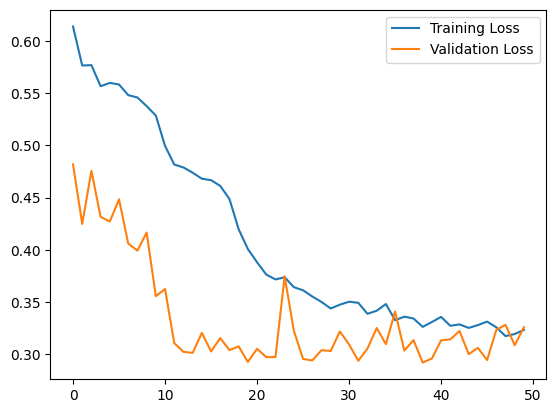

In [11]:
plt.plot(history_lstm1.history['loss'], label = 'Training Loss')
plt.plot(history_lstm1.history['val_loss'], label = 'Validation Loss')
plt.legend()

In [16]:
y_test = scaler.inverse_transform(y_test)
predictions_lstm1 = model.predict(x_test)
predictions_lstm1 = scaler.inverse_transform(predictions_lstm1)
print(f'LSTM rmse = {np.sqrt(np.mean((y_test - predictions_lstm1)**2)):.4f}')

32/32 [==============================] - 1s 35ms/step
LSTM rmse = 0.5030


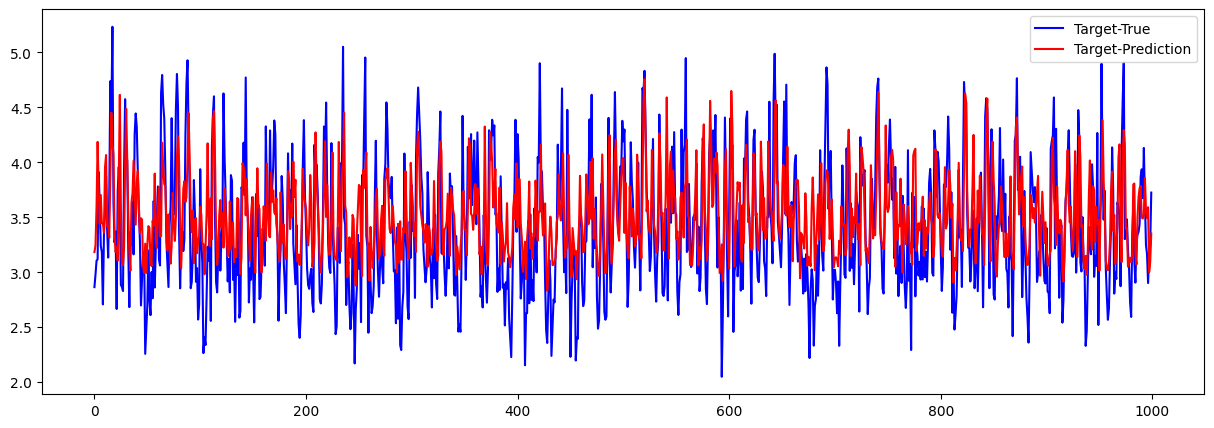

In [17]:
df_plot = pd.DataFrame({
    "time" : data.iloc[int(len(data) * 0.9):len(data),].index,
    "target_true" : y_test.squeeze(),
    "target_pred" : predictions_lstm1.squeeze()
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_plot.index, df_plot["target_true"], color = "blue", label = 'Target-True')
ax.plot(df_plot.index, df_plot["target_pred"], color = "red", label = 'Target-Prediction')
plt.legend()

## Only target feature - Feedforward NN

In [71]:
x_train, y_train = data_preparation(target_train, look_back)
x_val, y_val = data_preparation(target_val, look_back)
x_test, y_test = data_preparation(target_test, look_back)

x_train.shape, x_val.shape, x_test.shape

((6952, 48), (2000, 48), (1000, 48))

In [72]:
model = Sequential()
model.add(Dense(128, activation = "relu", input_dim=look_back))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               6272      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                

In [73]:
# fit the model
history_nn1 = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
55/55 [==============================] - 2s 8ms/step - loss: 1.1814 - val_loss: 0.9784
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 0.7633 - val_loss: 0.9125
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6751 - val_loss: 0.8854
Epoch 4/100
55/55 [==============================] - 0s 5ms/step - loss: 0.6282 - val_loss: 0.8896
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5838 - val_loss: 0.8282
Epoch 6/100
55/55 [==============================] - 0s 5ms/step - loss: 0.5433 - val_loss: 0.8775
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5354 - val_loss: 0.5940
Epoch 8/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5052 - val_loss: 0.7051
Epoch 9/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5048 - val_loss: 0.8624
Epoch 10/100
55/55 [==============================] - 0s 4ms/step - loss: 0.4831 - val_loss: 0.6137
Epoch 11/

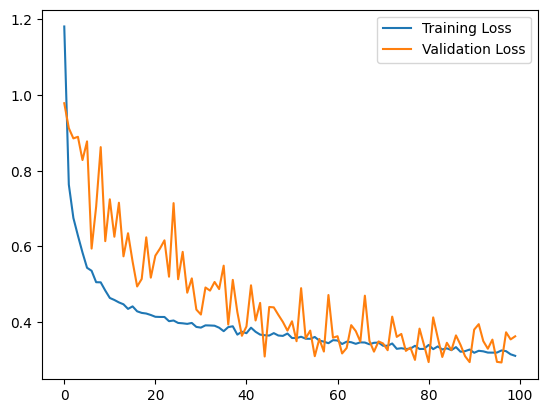

In [74]:
plt.plot(history_nn1.history['loss'], label = 'Training Loss')
plt.plot(history_nn1.history['val_loss'], label = 'Validation Loss')
plt.legend()

In [75]:
y_test = scaler.inverse_transform(y_test)
predictions_nn1 = model.predict(x_test)
predictions_nn1 = scaler.inverse_transform(predictions_nn1)
print(f'NN rmse = {np.sqrt(np.mean((y_test - predictions_nn1)**2)):.4f}')

32/32 [==============================] - 0s 2ms/step
NN rmse = 0.5344


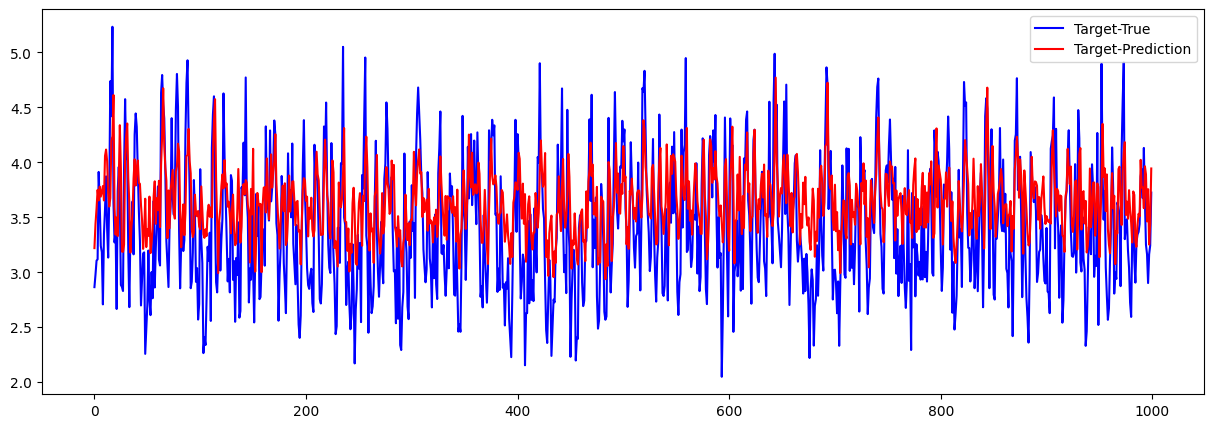

In [76]:
# Get real amp values
df_plot = pd.DataFrame({
    "time" : data.iloc[int(len(data) * 0.9):len(data),].index,
    "target_true" : y_test.squeeze(),
    "target_pred" : predictions_nn1.squeeze()
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_plot.index, df_plot["target_true"], color = "blue", label = 'Target-True')
ax.plot(df_plot.index, df_plot["target_pred"], color = "red", label = 'Target-Prediction')
plt.legend()

# RNN and NN with all features (Multivariable)

In [29]:
# Split data
look_back = 6
target_train = data.iloc[:int(len(data) * 0.7),:].values
target_val = data.iloc[(int(len(data) * 0.7) - look_back):int(len(data) * 0.9),:].values
target_test = data.iloc[(int(len(data) * 0.9) - look_back):,:].values

# scale data
scaler = StandardScaler().fit(target_train)
target_train = scaler.transform(target_train)
target_val = scaler.transform(target_val)
target_test = scaler.transform(target_test)

x_train, y_train = data_preparation(target_train, look_back)
x_val, y_val = data_preparation(target_val, look_back)
x_test, y_test = data_preparation(target_test, look_back)

### Podatkovni okvir zgradimo iz vsih podatko:
* $var_1(t-1), ..., var_1(t - look\_back), ..., var_{485}(t-1), ..., var_{485}(t - look\_back)$
* Model učimo napovedati vrednosti target spremenljivke ($var_{485}$) v času t.

In [44]:
x_train # number of cols = 485 * look_back(48) = 23280

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var476(t-1),var477(t-1),var478(t-1),var479(t-1),var480(t-1),var481(t-1),var482(t-1),var483(t-1),var484(t-1),var485(t-1)
6,-1.659886,-1.287853,-0.041359,3.366547,-0.380358,1.341127,-0.147497,-0.781463,-0.781463,-0.781463,...,0.0,0.0,0.0,0.0,0.0,-0.561009,0.561009,1.948894,-1.818623,0.659723
7,-0.726965,-0.477906,-0.041359,-0.304281,-0.324553,-0.386211,0.049284,-1.660090,-1.660090,-1.660090,...,0.0,0.0,0.0,0.0,0.0,-1.572862,1.572862,1.948359,-1.818242,1.286189
8,-0.722854,-0.471895,-0.041359,-0.324510,-0.317483,-0.386211,0.029090,-0.727038,-0.727038,-0.727038,...,0.0,0.0,0.0,0.0,0.0,-0.881014,0.881014,1.947824,-1.817861,0.292189
9,-0.722630,-0.471584,-0.041359,-0.324510,-0.317495,-0.386211,0.028507,-0.722927,-0.722927,-0.722927,...,0.0,0.0,0.0,0.0,0.0,0.131332,-0.131332,1.947289,-1.817480,1.027353
10,-0.722406,-0.471273,-0.041359,-0.324510,-0.317492,-0.386211,0.028082,-0.722702,-0.722702,-0.722702,...,0.0,0.0,0.0,0.0,0.0,1.143678,-1.143678,1.946754,-1.817100,1.474290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.855789,0.620300,-0.041359,-0.324510,-0.311007,-0.386211,1.069597,0.856301,0.856301,0.856301,...,0.0,0.0,0.0,0.0,0.0,0.163872,-0.163872,-0.846583,0.860845,-0.903876
6996,0.855465,0.540737,-0.041359,-0.324510,-0.269029,-0.386211,1.278372,0.855939,0.855939,0.855939,...,0.0,0.0,0.0,0.0,0.0,1.168876,-1.168876,-0.846048,0.860420,-1.604936
6997,0.855218,0.548847,-0.041359,-0.324510,-0.269929,-0.386211,1.257314,0.855615,0.855615,0.855615,...,0.0,0.0,0.0,0.0,0.0,1.288466,-1.288466,-0.845513,0.859995,-1.992333
6998,0.855148,0.989923,-0.041359,-0.321971,-0.370989,0.612171,-0.860248,0.855368,0.855368,0.855368,...,0.0,0.0,0.0,0.0,0.0,0.283706,-0.283706,-0.844987,0.859569,-2.004709


In [31]:
y_train

,var485(t)
6,1.286189
7,0.292189
8,1.027353
9,1.474290
10,0.676250
...,...
6995,-1.604936
6996,-1.992333
6997,-2.004709
6998,-1.255970


In [32]:
x_train = x_train.values.reshape(x_train.shape[0], look_back, target_train.shape[1])
x_val = x_val.values.reshape(x_val.shape[0], look_back, target_val.shape[1])
x_test = x_test.values.reshape(x_test.shape[0], look_back, target_test.shape[1])

x_train.shape, x_val.shape, x_test.shape

((6994, 6, 485), (2000, 6, 485), (1000, 6, 485))

In [33]:
# Build the LSTM model
model = Sequential(name="LSTM")
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.9))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.9))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.9))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 6, 64)             140800    
                                                                 
 dropout_15 (Dropout)        (None, 6, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 32)             12416     
                                                                 
 dropout_16 (Dropout)        (None, 6, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17     

In [34]:
# Train the model
history_lstm2 = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
55/55 [==============================] - 10s 52ms/step - loss: 1.2160 - val_loss: 2.6757
Epoch 2/50
55/55 [==============================] - 1s 22ms/step - loss: 1.0889 - val_loss: 2.7696
Epoch 3/50
55/55 [==============================] - 1s 22ms/step - loss: 0.9995 - val_loss: 2.6504
Epoch 4/50
55/55 [==============================] - 1s 22ms/step - loss: 0.9348 - val_loss: 2.5692
Epoch 5/50
55/55 [==============================] - 1s 22ms/step - loss: 0.8597 - val_loss: 2.6095
Epoch 6/50
55/55 [==============================] - 1s 22ms/step - loss: 0.8182 - val_loss: 2.5351
Epoch 7/50
55/55 [==============================] - 1s 22ms/step - loss: 0.8016 - val_loss: 2.5107
Epoch 8/50
55/55 [==============================] - 1s 22ms/step - loss: 0.7646 - val_loss: 2.5411
Epoch 9/50
55/55 [==============================] - 1s 22ms/step - loss: 0.7684 - val_loss: 2.4864
Epoch 10/50
55/55 [==============================] - 1s 21ms/step - loss: 0.7394 - val_loss: 2.4328
Epoch 11

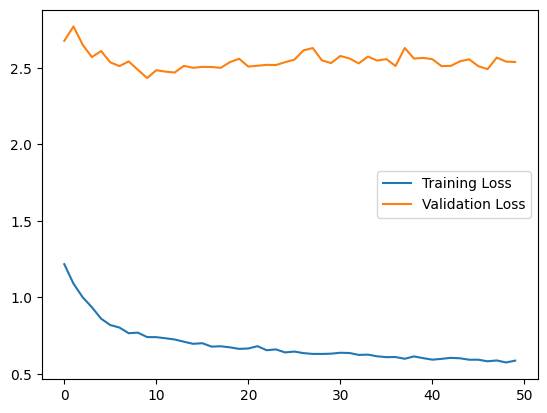

In [35]:
plt.plot(history_lstm2.history['loss'], label = 'Training Loss')
plt.plot(history_lstm2.history['val_loss'], label = 'Validation Loss')
plt.legend()

In [36]:
predictions_lstm2 = model.predict(x_test)
predictions_lstm2 = scaler.inverse_transform(np.repeat(predictions_lstm2, x_test.shape[2], axis=1))[:,484]
y_test_inv = scaler.inverse_transform(np.repeat(y_test, x_test.shape[2], axis=1))[:,484]
print(f'LSTM (Multivariate) rmse = {np.sqrt(np.mean((y_test_inv - predictions_lstm2)**2)):.4f}')

32/32 [==============================] - 2s 6ms/step
LSTM (Multivariate) rmse = 1.4717


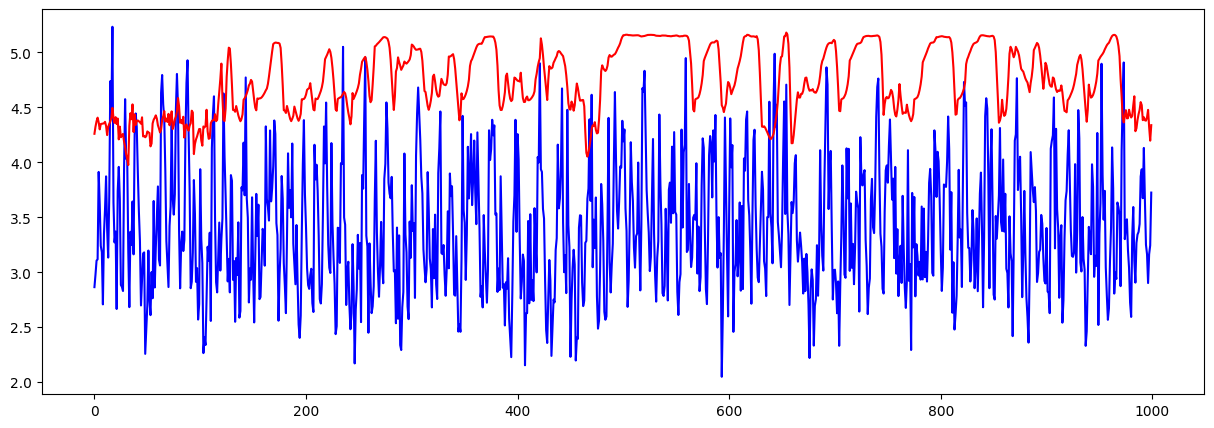

In [37]:
df_plot = pd.DataFrame({
    "time" : data.iloc[int(len(data) * 0.9):len(data),].index,
    "target_true" : y_test_inv,
    "target_pred" : predictions_lstm2
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_plot.index, df_plot["target_true"], color = "blue")
ax.plot(df_plot.index, df_plot["target_pred"], color = "red")

## Feedforward NN (Multivariate)

In [38]:
x_train, y_train = data_preparation(target_train, look_back)
x_val, y_val = data_preparation(target_val, look_back)
x_test, y_test = data_preparation(target_test, look_back)

x_train.shape, x_val.shape, x_test.shape

((6994, 2910), (2000, 2910), (1000, 2910))

In [39]:
model = Sequential()
model.add(Dense(64, activation = "relu", input_dim=x_train.shape[1]))
model.add(Dropout(0.9))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.9))
model.add(Dense(16, activation = "relu"))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                186304    
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                

In [40]:
# fit the model
history_nn2 = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
55/55 [==============================] - 2s 12ms/step - loss: 246.0058 - val_loss: 172.9820
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 156.6900 - val_loss: 26.1305
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 129.1351 - val_loss: 6.3774
Epoch 4/100
55/55 [==============================] - 0s 6ms/step - loss: 76.6006 - val_loss: 2.9510
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 53.5469 - val_loss: 2.1167
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 44.3787 - val_loss: 1.8044
Epoch 7/100
55/55 [==============================] - 0s 6ms/step - loss: 39.7805 - val_loss: 1.8250
Epoch 8/100
55/55 [==============================] - 0s 6ms/step - loss: 42.4850 - val_loss: 1.9535
Epoch 9/100
55/55 [==============================] - 0s 6ms/step - loss: 47.0241 - val_loss: 1.9424
Epoch 10/100
55/55 [==============================] - 0s 6ms/step - loss: 23.2497 - val_loss:

(0.0, 10.0)

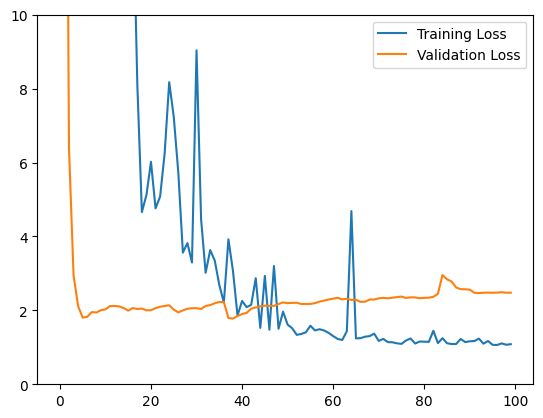

In [41]:
plt.plot(history_nn2.history['loss'], label = 'Training Loss')
plt.plot(history_nn2.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.ylim(0, 10)

In [42]:
predictions_nn2 = model.predict(x_test)
predictions_nn2 = scaler.inverse_transform(np.repeat(predictions_nn2, 485, axis=1))[:,484]
y_test = scaler.inverse_transform(np.repeat(y_test, 485, axis=1))[:,484]
print(f'NN (Multivariat) rmse = {np.sqrt(np.mean((y_test - predictions_nn2)**2)):.4f}')

32/32 [==============================] - 0s 2ms/step
NN (Multivariat) rmse = 1.4048


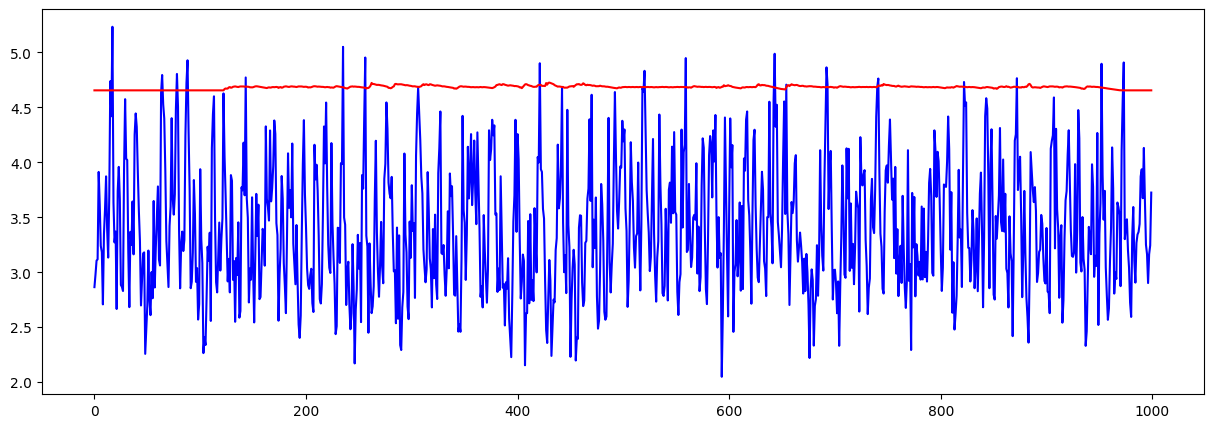

In [43]:
df_plot = pd.DataFrame({
    "time" : data.iloc[int(len(data) * 0.9):len(data),].index,
    "target_true" : y_test,
    "target_pred" : predictions_nn2
})

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_plot.index, df_plot["target_true"], color = "blue")
ax.plot(df_plot.index, df_plot["target_pred"], color = "red")